In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import shap

In [17]:
df = pd.read_csv('data/ilpd-clustered.csv')

In [18]:
df.columns

Index(['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB',
       'A/G Ratio', 'Clusters_KProto_k2', 'Clusters_KProto_k4',
       'Clusters_KProto_k5', 'Clusters_GMM_k2', 'Clusters_GMM_k4',
       'Clusters_GMM_k7', 'Clusters_HDBScan_MinClusters5',
       'Clusters_HDBScan_MinClusters6', 'Clusters_Spectral_k2',
       'Clusters_Spectral_k4', 'Clusters_Spectral_k6', 'Label'],
      dtype='object')

In [43]:
# Features (drop cluster columns and label)
X_features = df.drop(columns=[col for col in df.columns if col.startswith("Clusters_")]+['Label'])

# Cluster labels as target
y_target = df['Clusters_Spectral_k4']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42, stratify=y_target
)

In [47]:
# Encode categorical columns
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

for col in X_train.select_dtypes(include=['object', 'category']):
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train[col])
    X_test_enc[col] = le.transform(X_test[col])

# Train Random Forest
rf = RandomForestClassifier(n_estimators=5, random_state=42)
rf.fit(X_train_enc, y_train)

,n_estimators,5
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
y_pred = rf.predict(X_test_enc)

# --- Basic metrics ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1:.3f}")

# --- Detailed class-by-class report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# --- Optional: Confusion matrix ---
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

Accuracy : 0.914
Precision: 0.916
Recall   : 0.914
F1-score : 0.914

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        34
           1       1.00      1.00      1.00        26
           2       1.00      0.93      0.97        15
           3       0.90      0.85      0.88        41

    accuracy                           0.91       116
   macro avg       0.93      0.92      0.93       116
weighted avg       0.92      0.91      0.91       116

Confusion Matrix:


array([[31,  0,  0,  3],
       [ 0, 26,  0,  0],
       [ 0,  0, 14,  1],
       [ 6,  0,  0, 35]])

In [50]:
rf.score(X_train_enc, y_train), rf.score(X_test_enc, y_test)

(0.9935205183585313, 0.9137931034482759)

In [51]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train_enc.columns)
feat_importances = feat_importances.sort_values(ascending=False)
print(feat_importances)

Gender       0.339928
ALB          0.190927
DB           0.105400
Age          0.076498
TP           0.070717
TB           0.066180
Alkphos      0.046714
Sgot         0.043278
A/G Ratio    0.032415
Sgpt         0.027943
dtype: float64


In [52]:
perm_importance = permutation_importance(rf, X_test_enc, y_test, n_repeats=10, random_state=42)
perm_df = pd.Series(perm_importance.importances_mean, index=X_train_enc.columns).sort_values(ascending=False)
print(perm_df)

Gender       0.304310
ALB          0.177586
DB           0.107759
Age          0.056034
TB           0.037069
TP           0.010345
A/G Ratio    0.002586
Sgot        -0.010345
Alkphos     -0.014655
Sgpt        -0.018103
dtype: float64


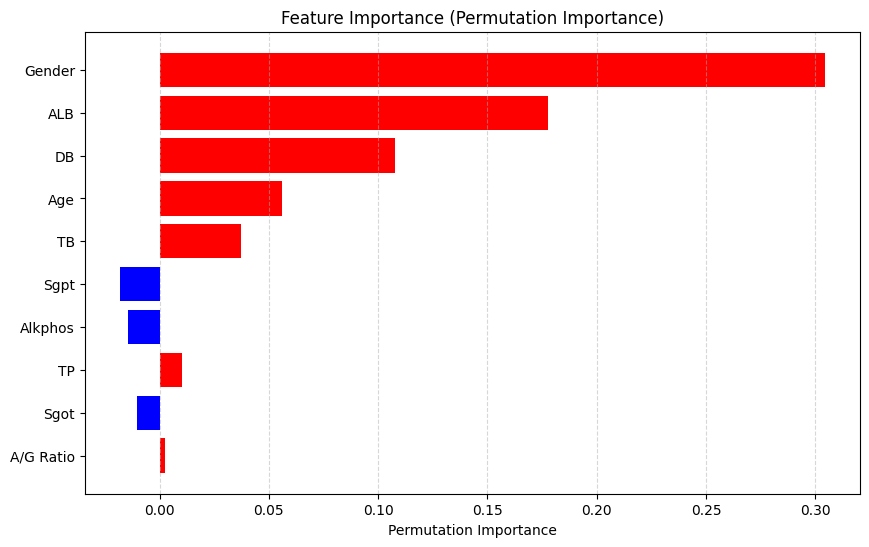

In [78]:
# Sort the features by importance
perm_df_sorted = perm_df.reindex(perm_df.abs().sort_values(ascending=True).index)

# Set colors: red for positive, blue for negative
colors = ['red' if v > 0 else 'blue' for v in perm_df_sorted.values]

# Create horizontal bar plot
plt.figure(figsize=(10,6))
plt.barh(perm_df_sorted.index, perm_df_sorted.values, color=colors)
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation Importance)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

[[[ 1.03324294e-01 -2.05269454e-03  8.32570397e-03 -1.09597303e-01]
  [ 1.79738969e-01 -2.34222041e-01  4.57021384e-03  4.99128581e-02]
  [ 6.06686440e-03  3.14040645e-04 -2.33543127e-02  1.69734076e-02]
  ...
  [ 8.51303139e-02  2.03739070e-03 -5.08937282e-03 -8.20783317e-02]
  [ 2.68621789e-01  7.96883019e-03 -3.24948916e-02 -2.44095727e-01]
  [ 2.32586915e-02  1.13167959e-03 -9.52778599e-03 -1.48625851e-02]]

 [[ 1.55409465e-02  6.51126494e-03  4.30977872e-04 -2.24831893e-02]
  [-5.04462145e-01  7.03354108e-01 -1.48834212e-02 -1.84008542e-01]
  [ 1.57951159e-03  8.39032835e-03 -1.95014560e-02  9.53161606e-03]
  ...
  [ 4.70674959e-02  8.09900655e-03 -4.01053391e-03 -5.11559686e-02]
  [ 1.35742172e-01  8.65564029e-03 -1.99428034e-02 -1.24455009e-01]
  [ 1.09194944e-02  2.07680079e-03 -5.09334146e-03 -7.90295377e-03]]

 [[ 3.76758039e-02  3.35470371e-03  1.77659004e-04 -4.12081666e-02]
  [ 1.79859030e-01 -2.36018899e-01  1.05981026e-02  4.55617668e-02]
  [ 2.63346270e-03  2.41349843e-

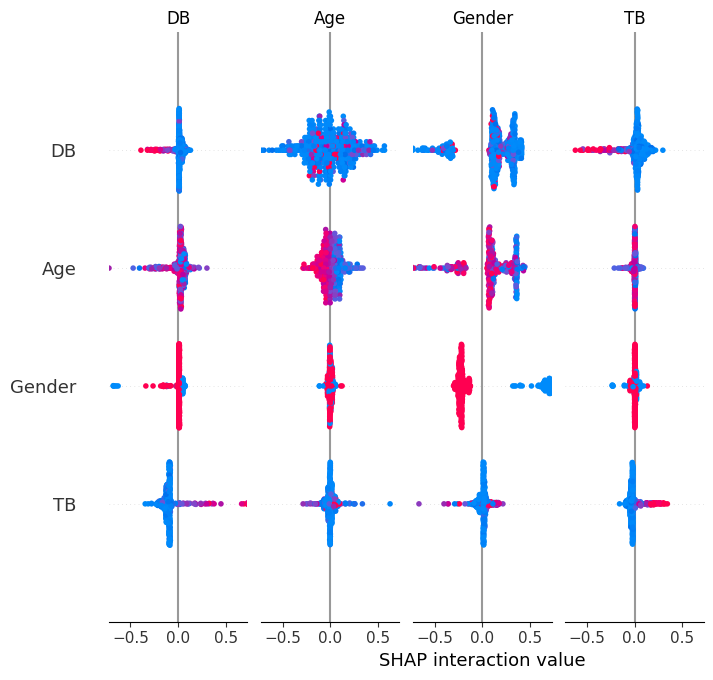

In [57]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_enc)

print(shap_values)
# Summary plot for cluster 0 vs rest
shap.summary_plot(shap_values, X_train_enc)

# https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

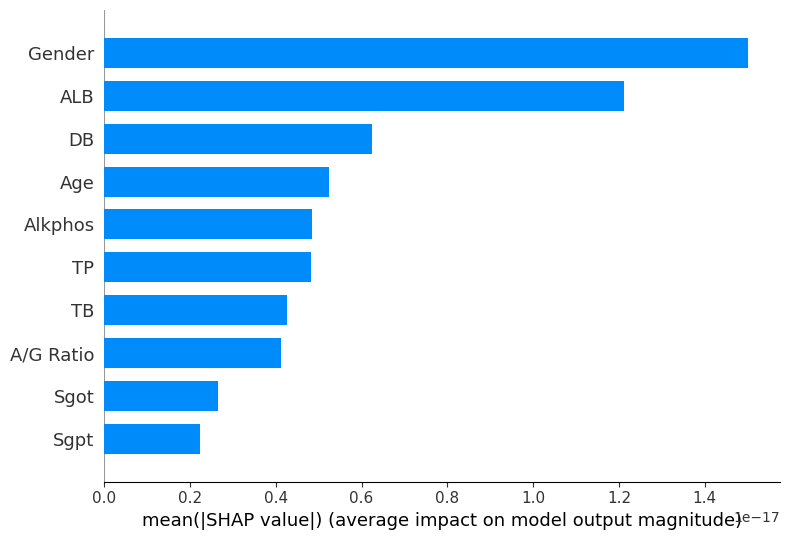

In [67]:
# Convert list of arrays (one per class) into a single 3D array
shap_values_array = np.stack(shap_values)  # shape: (n_classes, n_samples, n_features)

# Compute mean absolute SHAP value across classes
shap_values_combined = np.mean(np.abs(shap_values_array), axis=2)  # shape: (n_samples, n_features)

# Now plot a single summary (bar) plot
shap.summary_plot(shap_values_combined, X_train_enc, plot_type="bar")

In [65]:
print(shap_values_array.shape)
print(X_train_enc.shape)


(463, 10, 4)
(463, 10)


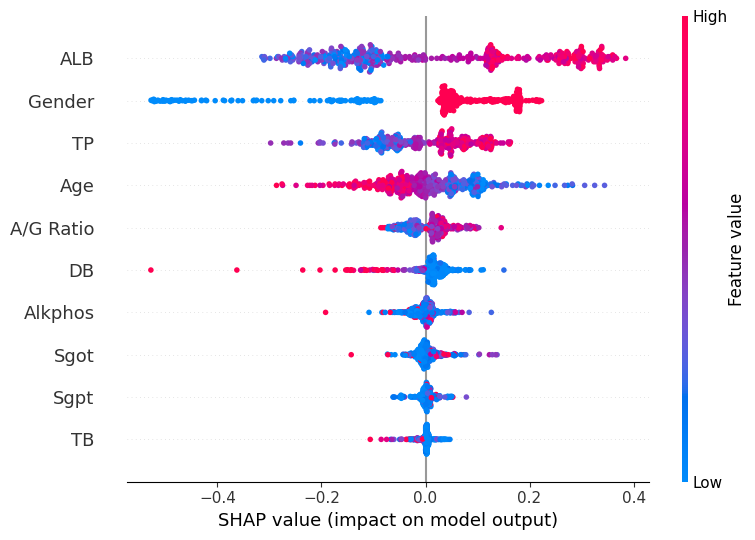

In [70]:
shap.summary_plot(shap_values[:, :, 0], X_train_enc) # Just for cluster 0!!!!

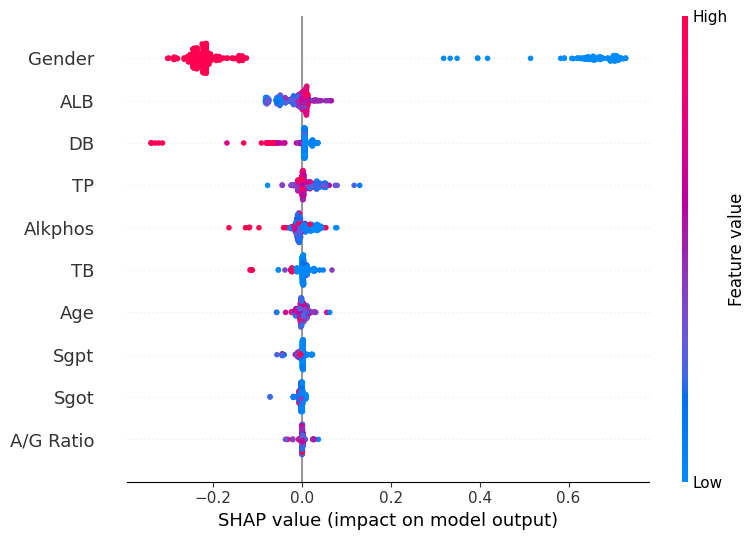

In [71]:
shap.summary_plot(shap_values[:, :, 1], X_train_enc) # Just for cluster 1!!!!

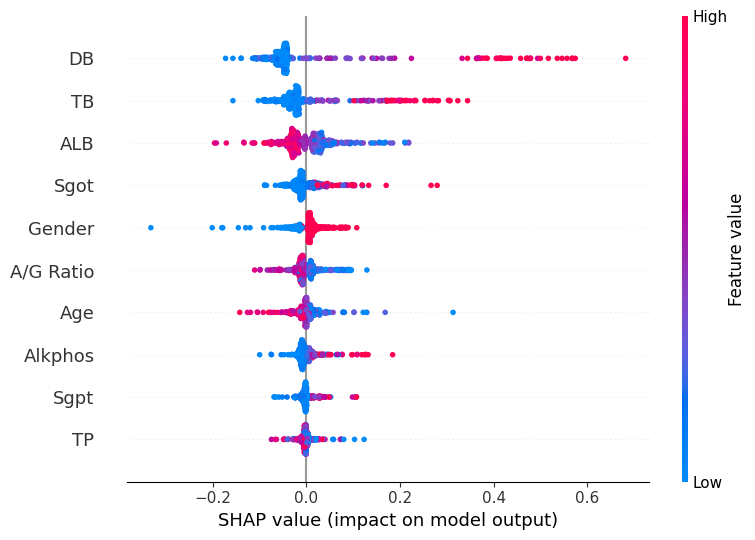

In [72]:
shap.summary_plot(shap_values[:, :, 2], X_train_enc) # Just for cluster 2!!!!

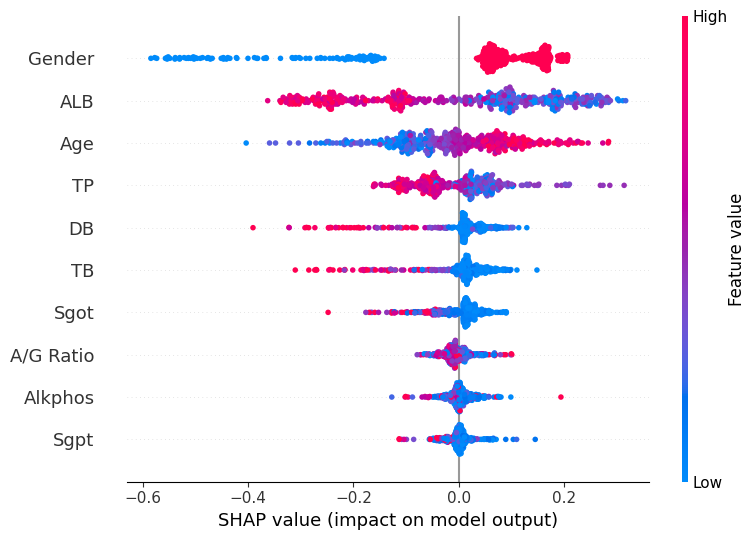

In [73]:
shap.summary_plot(shap_values[:, :, 3], X_train_enc) # Just for cluster 3!!!!